In [143]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, roc_auc_score
import warnings

warnings.filterwarnings("ignore")

In [4]:
D_ITEMS = pd.read_csv("/data/PUBLIC_DATA/MIMIC-III/D_ITEMS.csv")
df = pd.read_csv("/home/watercar99/project/MIMIC-III/chartdata_24h.csv")
ards = pd.read_csv("/home/watercar99/project/MIMIC-III/ARDS.csv")

### 1. OI&OSI score 계산 위해 필요한 column 추출

#### 1-1. Mean airway pressure

In [6]:
# D_ITEMS[D_ITEMS['LABEL'].str.contains('MEAN AIR',na=False)]
D_ITEMS[D_ITEMS['LABEL'].str.contains('way', na=False) | D_ITEMS['ABBREVIATION'].str.contains('way', na=False)]

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
149,1301,1209,HFO mean airway Pres,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
308,45,38,Airway,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
309,46,39,Airway Size,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
310,47,40,Airway Type,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
407,144,141,Cuff Pressure-Airway,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
673,410,444,Mean Airway Pressure,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
2007,3241,1864,HFO-Max mean airway,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
2008,3242,1865,HFO-Min mean airway,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
9449,14626,226815,Airway problems,Airway problems,metavision,chartevents,Respiratory,NaN,Text,NaN
10059,13251,224697,Mean Airway Pressure,Mean Airway Pressure,metavision,chartevents,Respiratory,cmH2O,Numeric,NaN


In [18]:
item_list = [224322, 444, 227023, 224322, 224697]
# item_list = []

df1 = df.merge(ards[["SUBJECT_ID", "HADM_ID"]], on=["SUBJECT_ID", "HADM_ID"], how="inner")
df1 = df1[df1['ITEMID'].isin(item_list)]
df1 = df1[["SUBJECT_ID", "HADM_ID", "ITEMID", "CHARTTIME", "VALUE"]]
df1.fillna(0, inplace=True)  # 결측치를 0으로 변경
df2 = df1.groupby(['SUBJECT_ID', 'HADM_ID'], as_index=False).agg({'VALUE': lambda x: np.mean(x.astype(float))}) # 평균 구하기

# 결과 출력
print("전체 N 수:", len(df2))
print("전체 평균 (Overall Mean):", df2["VALUE"].mean())
print("전체 표준편차 (Overall Standard Deviation):", df2["VALUE"].std())
df2

# df2.to_csv("~/project/MIMIC-III/Data/OI&OSI/mean_airway_pressure.csv", index=False)

전체 N 수: 4431
전체 평균 (Overall Mean): 11.244065161438602
전체 표준편차 (Overall Standard Deviation): 6.104618627328197


,SUBJECT_ID,HADM_ID,VALUE
0,101,175533,13.450000
1,111,192123,10.666667
2,141,168006,13.100000
3,148,199488,7.000000
4,165,170252,7.000000
...,...,...,...
4426,99881,172327,20.857143
4427,99899,188409,10.833333
4428,99912,189380,8.000000
4429,99939,159023,10.625000


#### 1-2. SpO2

In [9]:
# D_ITEMS[D_ITEMS['LABEL'].str.contains('SpO2',na=False)]
D_ITEMS[D_ITEMS['LABEL'].str.contains('SpO2', na=False) | D_ITEMS['ABBREVIATION'].str.contains('SpO2', na=False)]

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
1418,599,646,SpO2,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
2469,1923,5820,SpO2 Alarm [Low],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
4804,4998,8554,SpO2 Alarm [High],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
5080,4343,6719,SpO2-L,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
11926,14442,226253,SpO2 Desat Limit,SpO2 Desat Limit,metavision,chartevents,Alarms,%,Numeric,NaN
12355,12746,220277,O2 saturation pulseoxymetry,SpO2,metavision,chartevents,Respiratory,%,Numeric,NaN
12374,12765,223769,O2 Saturation Pulseoxymetry Alarm - High,SpO2 Alarm - High,metavision,chartevents,Alarms,%,Numeric,NaN
12375,12766,223770,O2 Saturation Pulseoxymetry Alarm - Low,SpO2 Alarm - Low,metavision,chartevents,Alarms,%,Numeric,NaN


In [20]:
item_list = [646, 5820, 8554, 226253, 220277, 223769, 223770]
# item_list = []

df1 = df.merge(ards[["SUBJECT_ID", "HADM_ID"]], on=["SUBJECT_ID", "HADM_ID"], how="inner")
df1 = df1[df1['ITEMID'].isin(item_list)]
df1 = df1[["SUBJECT_ID", "HADM_ID", "ITEMID", "CHARTTIME", "VALUE"]]
df1.fillna(0, inplace=True)  # 결측치를 0으로 변경
df2 = df1.groupby(['SUBJECT_ID', 'HADM_ID'], as_index=False).agg({'VALUE': lambda x: np.mean(x.astype(float))}) # 평균 구하기

# 결과 출력
print("전체 N 수:", len(df2))
print("전체 평균 (Overall Mean):", df2["VALUE"].mean())
print("전체 표준편차 (Overall Standard Deviation):", df2["VALUE"].std())
df2

# df2.to_csv("~/project/MIMIC-III/Data/OI&OSI/SpO2.csv", index=False)

전체 N 수: 5739
전체 평균 (Overall Mean): 95.45997655631295
전체 표준편차 (Overall Standard Deviation): 5.840894849086765


,SUBJECT_ID,HADM_ID,VALUE
0,91,121205,98.700000
1,101,175533,97.483871
2,111,192123,97.400000
3,141,168006,87.269231
4,148,199488,93.086957
...,...,...,...
5734,99881,172327,94.971429
5735,99899,188409,96.638889
5736,99912,189380,95.297297
5737,99939,159023,96.846154


#### 1-3. PaO2

In [36]:
# D_ITEMS[D_ITEMS['LABEL'].str.contains('PaO2',na=False)]
D_ITEMS[D_ITEMS['LABEL'].str.contains('PaO2', na=False) | D_ITEMS['ABBREVIATION'].str.contains('PaO2', na=False)]

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
1518,699,779,Arterial PaO2,NaN,carevue,chartevents,ABG,NaN,NaN,NaN


In [39]:
# PaO2
# item_list = [779(Arterial PaO2), 490(PAO2 - 779보다 분포 큼 + 1명 추가됨 + 사용할 경우 mean, SD 2씩 증가)]
item_list = [779, 490]

# PO2
# item_list = [227516, 220224(227516보다 분포 큼), 226063]
# item_list = [227039]

# PaO2&PO2
# item_list = [779, 227516]

df1 = df.merge(ards[["SUBJECT_ID", "HADM_ID"]], on=["SUBJECT_ID", "HADM_ID"], how="inner")
df1 = df1[df1['ITEMID'].isin(item_list)]
df1 = df1[["SUBJECT_ID", "HADM_ID", "ITEMID", "CHARTTIME", "VALUE"]]
df1.fillna(0, inplace=True)  # 결측치를 0으로 변경
df2 = df1.groupby(['SUBJECT_ID', 'HADM_ID'], as_index=False).agg({'VALUE': lambda x: np.mean(x.astype(float))}) # 평균 구하기

# 결과 출력
print("전체 N 수:", len(df2))
print("전체 평균 (Overall Mean):", df2["VALUE"].mean())
print("전체 표준편차 (Overall Standard Deviation):", df2["VALUE"].std())
df2

# df2.to_csv("~/project/MIMIC-III/Data/OI&OSI/PaO2.csv", index=False)

전체 N 수: 2676
전체 평균 (Overall Mean): 140.5403865762387
전체 표준편차 (Overall Standard Deviation): 62.297274096340175


,SUBJECT_ID,HADM_ID,VALUE
0,91,121205,131.000000
1,101,175533,115.428571
2,111,192123,153.800000
3,141,168006,129.857143
4,148,199488,96.000000
...,...,...,...
2671,32779,133757,203.000000
2672,32781,142684,245.800000
2673,32786,165351,143.500000
2674,32800,179038,193.400000


#### 1-4. FiO2

In [14]:
# D_ITEMS[D_ITEMS['LABEL'].str.contains('FiO2',na=False)]
D_ITEMS[D_ITEMS['LABEL'].str.contains('FIO2', na=False) | D_ITEMS['ABBREVIATION'].str.contains('FIO2', na=False)]

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
45,1197,1040,BIpap FIO2,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
146,1298,1206,HFO FIO2:,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
449,186,185,FIO2 Alarm-High,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
450,187,186,FIO2 Alarm-Low,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
1838,1019,3420,FIO2,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
1839,1020,3421,FIO2 Alarm [Low],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
1840,1021,3422,FIO2 [Meas],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
3243,3612,2518,HFO- FIO2,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
4506,4700,7570,FIO2 SET,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
4774,4968,8517,FIO2 Alarm [High],NaN,carevue,chartevents,NaN,NaN,NaN,NaN


In [41]:
# item_list = [189, 190] # 1 이하인 FiO2 칼럼 모음 - 아마 100 곱해서 사용해야할듯
# item_list = [727, 227010(1개),223835 ,226754, 185, 186] # 1이상인 FiO2 칼럼 모음
item_list = [727, 227010,223835 ,226754, 185, 186]

df1 = df.merge(ards[["SUBJECT_ID", "HADM_ID"]], on=["SUBJECT_ID", "HADM_ID"], how="inner")
df1 = df1[df1['ITEMID'].isin(item_list)]
df1 = df1[["SUBJECT_ID", "HADM_ID", "ITEMID", "CHARTTIME", "VALUE"]]
df1.fillna(0, inplace=True)  # 결측치를 0으로 변경
df2 = df1.groupby(['SUBJECT_ID', 'HADM_ID'], as_index=False).agg({'VALUE': lambda x: np.mean(x.astype(float))}) # 평균 구하기

# 결과 출력
print("전체 N 수:", len(df2))
print("전체 평균 (Overall Mean):", df2["VALUE"].mean())
print("전체 표준편차 (Overall Standard Deviation):", df2["VALUE"].std())
df2

# df2.to_csv("~/project/MIMIC-III/Data/OI&OSI/FiO2.csv", index=False)

전체 N 수: 2417
전체 평균 (Overall Mean): 56.644889297406245
전체 표준편차 (Overall Standard Deviation): 18.510833488956024


,SUBJECT_ID,HADM_ID,VALUE
0,165,170252,50.000000
1,188,123860,40.000000
2,268,110404,25.000000
3,356,192219,0.000000
4,422,117029,34.444444
...,...,...,...
2412,99881,172327,76.923077
2413,99899,188409,57.272727
2414,99912,189380,60.000000
2415,99939,159023,56.250000


### 2. calculate OI&OSI

In [42]:
ap = pd.read_csv("~/project/MIMIC-III/Data/OI&OSI/mean_airway_pressure.csv")
spo2 = pd.read_csv("~/project/MIMIC-III/Data/OI&OSI/SpO2.csv")
pao2 = pd.read_csv("~/project/MIMIC-III/Data/OI&OSI/PaO2.csv")
fio2 = pd.read_csv("~/project/MIMIC-III/Data/OI&OSI/FiO2.csv")

In [56]:
data = pd.merge(ap, spo2, on=['SUBJECT_ID', 'HADM_ID'])
data.rename(columns={'VALUE_x':'MAP', 'VALUE_y':'SpO2'}, inplace=True)

data = pd.merge(data, pao2, on=['SUBJECT_ID', 'HADM_ID'])
data.rename(columns={'VALUE':'PaO2'}, inplace=True)

data = pd.merge(data, fio2, on=['SUBJECT_ID', 'HADM_ID'])
data.rename(columns={'VALUE':'FiO2'}, inplace=True)

data = pd.merge(data, ards, on=['SUBJECT_ID', 'HADM_ID'])
data

,SUBJECT_ID,HADM_ID,MAP,SpO2,PaO2,FiO2,y
0,268,110404,16.800000,95.296296,90.500000,25.000000,1
1,356,192219,8.550000,95.714286,105.200000,0.000000,1
2,436,114621,9.150000,99.636364,188.000000,50.000000,1
3,497,152166,19.257143,94.324324,97.125000,66.428571,0
4,518,107636,13.428571,96.565854,188.000000,16.000000,0
...,...,...,...,...,...,...,...
189,32436,184018,11.857143,97.361111,168.000000,54.285714,0
190,32443,184083,8.857143,95.403846,196.666667,37.500000,1
191,32525,135066,7.500000,94.975610,120.142857,41.111111,0
192,32605,157470,15.666667,94.390244,70.000000,64.285714,0


In [129]:
def calculate_OI(df):
    data['OI'] = data['FiO2'] * data['MAP'] / data['PaO2']
    return data

def calculate_OSI(df):
    data['OSI'] = data['FiO2'] * data['MAP'] / data['SpO2']    
    return data

data = calculate_OI(data)
data = calculate_OSI(data)
data = data[(data['OI'] != 0) & (data['OSI'] != 0)] # OI, OSI score 0인 값 제거
data

,SUBJECT_ID,HADM_ID,MAP,SpO2,PaO2,FiO2,y,OI,OSI,severity
0,268,110404,16.800000,95.296296,90.500000,25.000000,1,4.640884,4.407307,mild
2,436,114621,9.150000,99.636364,188.000000,50.000000,1,2.433511,4.591697,unknown
3,497,152166,19.257143,94.324324,97.125000,66.428571,0,13.170909,13.561979,severe
4,518,107636,13.428571,96.565854,188.000000,16.000000,0,1.142857,2.224981,unknown
5,674,116577,7.000000,95.419753,91.000000,20.000000,0,1.538462,1.467201,unknown
...,...,...,...,...,...,...,...,...,...,...
189,32436,184018,11.857143,97.361111,168.000000,54.285714,0,3.831390,6.611197,mild
190,32443,184083,8.857143,95.403846,196.666667,37.500000,1,1.688862,3.481441,unknown
191,32525,135066,7.500000,94.975610,120.142857,41.111111,0,2.566389,3.246448,unknown
192,32605,157470,15.666667,94.390244,70.000000,64.285714,0,14.387755,10.669989,moderate


In [79]:
# data.to_csv("~/project/MIMIC-III/Data/OI&OSI/new_OI&OSI.csv", index=False)

In [132]:
# OI, OSI 칼럼의 mean, max, min, SD 계산
print("ards 데이터:", len(ards))
print("OI&OSI 데이터:", len(data))
print("")
print("OI&OSI 데이터의 y label 비율:")
print(data['y'].value_counts())
print("")
print("OI 열의 평균:", data["OI"].mean())
print("OI 열의 최소:", data["OI"].min())
print("OI 열의 최대:", data["OI"].max())
print("OI 열의 표준편차:", data["OI"].std())
print("")
print("OSI 열의 평균:", data["OSI"].mean())
print("OSI 열의 최소:", data["OSI"].min())
print("OSI 열의 최대:", data["OSI"].max())
print("OSI 열의 표준편차:", data["OSI"].std())

ards 데이터: 5888
OI&OSI 데이터: 175

OI&OSI 데이터의 y label 비율:
0    126
1     49
Name: y, dtype: int64

OI 열의 평균: 4.021127992820739
OI 열의 최소: 0.13260869617047516
OI 열의 최대: 25.754231052244297
OI 열의 표준편차: 4.195104503841104

OSI 열의 평균: 4.728851004180118
OSI 열의 최소: 0.42665406593978966
OSI 열의 최대: 25.801777324956124
OSI 열의 표준편차: 3.675484293175785


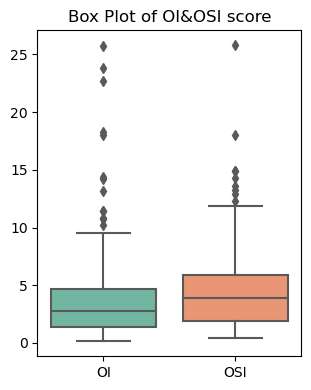

In [133]:
plt.figure(figsize=(6, 4))

# 박스 플롯 그리기
plt.subplot(1, 2, 1)
sns.boxplot(data=data[["OI", "OSI"]], palette="Set2")
plt.title("Box Plot of OI&OSI score")

plt.tight_layout()
plt.show()

In [134]:
import pandas as pd

# severity level of OI, OSI
def assign_severity(row):
    if row['OI'] >= 16 or row['OSI'] >= 12.3:
        return 'severe'
    elif 8 <= row['OI'] < 16 or 7.5 <= row['OSI'] < 12.3:
        return 'moderate'
    elif 4 <= row['OI'] < 8 or 5 <= row['OSI'] < 7.5:
        return 'mild'
    else:
        return 'unknown'

# data에 severity column 추가
data['severity'] = data.apply(assign_severity, axis=1)

# severity level별 y column이 1인 비율 계산 (inhospital mortality rate) + level 별 개수 count
severity_counts = data.groupby('severity')['y'].mean().round(4) * 100
severity_counts = pd.concat([severity_counts, data['severity'].value_counts()], axis=1)
severity_counts.columns = ['mortality rate', 'count']

severity_counts

,mortality rate,count
mild,32.61,46
moderate,41.67,24
severe,62.50,8
unknown,19.59,97


### 3. OI&OSI cut

In [136]:
data = pd.read_csv("~/project/MIMIC-III/Data/OI&OSI/new_OI&OSI.csv")
data = data[["SUBJECT_ID", "HADM_ID", "OI", "OSI", "y"]]
data

,SUBJECT_ID,HADM_ID,OI,OSI,y
0,268,110404,4.640884,4.407307,1
1,436,114621,2.433511,4.591697,1
2,497,152166,13.170909,13.561979,0
3,518,107636,1.142857,2.224981,0
4,674,116577,1.538462,1.467201,0
...,...,...,...,...,...
170,32436,184018,3.831390,6.611197,0
171,32443,184083,1.688862,3.481441,1
172,32525,135066,2.566389,3.246448,0
173,32605,157470,14.387755,10.669989,0


#### 3-1. OI cut

In [161]:
# OI 값을 기준으로 리스트들을 함께 정렬
sorted_lists = sorted(zip(data['OI'], data['y']))
sorted_OI, sorted_y = zip(*sorted_lists)

# 컷 값을 선택하는 부분
best_cut = None
best_f1 = 0
best_accuracy = 0
best_precision = 0
best_recall = 0
best_auroc = 0  # AUROC 초기화

for i in range(1, len(sorted_OI)):
    y_left = sorted_y[:i]
    y_right = sorted_y[i:]
    
    tp = y_left.count(1) + y_right.count(1)
    fp = y_left.count(0) + y_right.count(1)
    fn = y_left.count(1) + y_right.count(0)
    tn = y_left.count(0) + y_right.count(0)
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    f1 = 2 * (precision * recall) / (precision + recall)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    probas = [0] * len(sorted_y)
    probas[i:] = [1] * len(y_right)
    auroc = roc_auc_score(sorted_y, probas)
    
    if f1 > best_f1:
        best_f1 = f1
        best_cut = (sorted_OI[i-1] + sorted_OI[i]) / 2  # 인접한 값의 중간 지점 선택
        best_accuracy = accuracy
        best_precision = precision
        best_recall = recall
        best_auroc = auroc

print("OI Best cut:", best_cut)

print("Best Accuracy:", best_accuracy)
print("Best Precision:", best_precision)
print("Best Recall:", best_recall)
print("Best F1 Score:", best_f1)
print("Best AUROC:", best_auroc)


OI Best cut: 0.5589561603011529
Best Accuracy: 0.5
Best Precision: 0.4666666666666667
Best Recall: 0.2916666666666667
Best F1 Score: 0.35897435897435903
Best AUROC: 0.5215419501133787


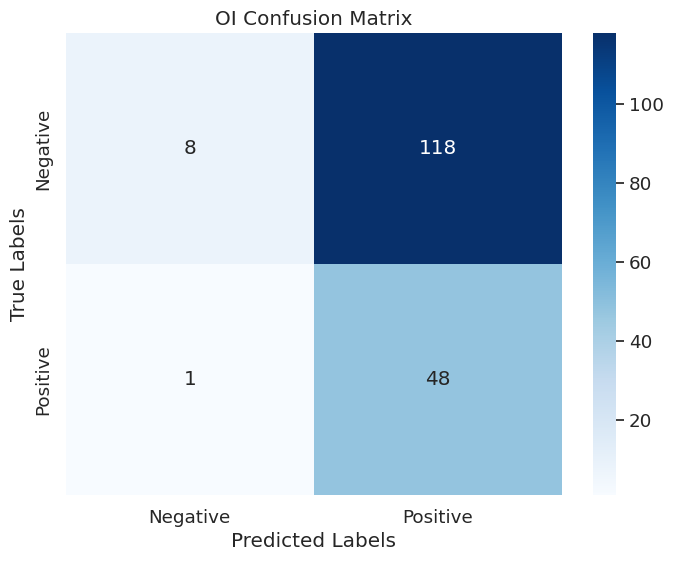

In [162]:
# best_cut 값을 사용하여 y_pred 생성
y_pred = [0 if value <= best_cut else 1 for value in data['OI']]

conf_matrix = confusion_matrix(data['y'], y_pred)

labels = ["Negative", "Positive"]

# 혼동 행렬을 시각화
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("OI Confusion Matrix")
plt.show()

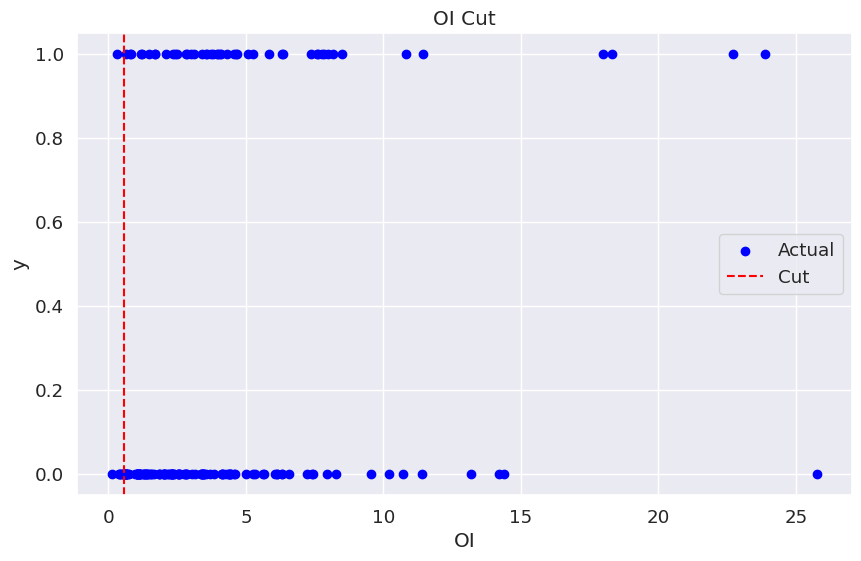

In [163]:
# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.scatter(sorted_OI, sorted_y, color='blue', label='Actual')
plt.axvline(x=best_cut, color='red', linestyle='--', label='Cut')
plt.xlabel('OI')
plt.ylabel('y')
plt.title('OI Cut')
plt.legend()
plt.show()

In [164]:
data_1 = data[data['y']==1]['OI']
data_0 = data[data['y']==0]['OI']

print(data_1.median(),data_0.median())

4.063786008230453 2.304300637633971


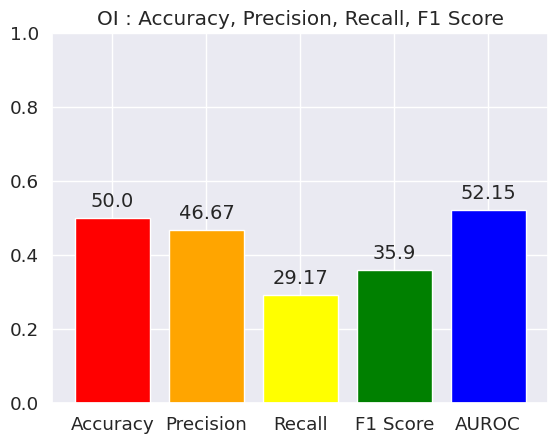

In [165]:
# 그래프 그리기
labels = ['Accuracy','Precision', 'Recall','F1 Score', "AUROC"]
values = [best_accuracy, best_precision, best_recall, best_f1, best_auroc]

fig, ax = plt.subplots()
bars = ax.bar(labels, values, color=['red', 'orange','yellow','green', 'blue'])
# plt.ylabel('Value')
plt.title('OI : Accuracy, Precision, Recall, F1 Score')
plt.ylim(0, 1) 

# 막대 내부에 큰 글꼴 크기로 수치 표시
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4)*100, ha='center', va='bottom', fontsize=14)  # fontsize 조정

plt.show()

In [166]:
# y_pred 리스트 내의 값을 카운트
value_counts1 = Counter(data['y'])
value_counts2 = Counter(y_pred)

print("Value Counts:", value_counts1)
print("Value Counts:", value_counts2)

Value Counts: Counter({0: 126, 1: 49})
Value Counts: Counter({1: 166, 0: 9})


#### 3-2. OSI cut

In [173]:
# OSI 값을 기준으로 리스트들을 함께 정렬
sorted_lists = sorted(zip(data['OSI'], data['y']))
sorted_OSI, sorted_y = zip(*sorted_lists)

# 컷 값을 선택하는 부분
best_cut = None
best_f1 = 0
best_accuracy = 0
best_precision = 0
best_recall = 0
best_auroc = 0  # AUROC 초기화

for i in range(1, len(sorted_OSI)):
    y_left = sorted_y[:i]
    y_right = sorted_y[i:]
    
    tp = y_left.count(1) + y_right.count(1)
    fp = y_left.count(0) + y_right.count(1)
    fn = y_left.count(1) + y_right.count(0)
    tn = y_left.count(0) + y_right.count(0)
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    f1 = 2 * (precision * recall) / (precision + recall)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    probas = [0] * len(sorted_y)
    probas[i:] = [1] * len(y_right)
    auroc = roc_auc_score(sorted_y, probas)
    
    if f1 > best_f1:
        best_f1 = f1
        best_cut = (sorted_OSI[i-1] + sorted_OSI[i]) / 2  # 인접한 값의 중간 지점 선택
        best_accuracy = accuracy
        best_precision = precision
        best_recall = recall
        best_auroc = auroc

print("OSI Best cut:", best_cut)
print("Best Accuracy:", best_accuracy)
print("Best Precision:", best_precision)
print("Best Recall:", best_recall)
print("Best F1 Score:", best_f1)
print("Best AUROC:", best_auroc)

OSI Best cut: 0.963520817827374
Best Accuracy: 0.5
Best Precision: 0.4666666666666667
Best Recall: 0.2916666666666667
Best F1 Score: 0.35897435897435903
Best AUROC: 0.5215419501133787


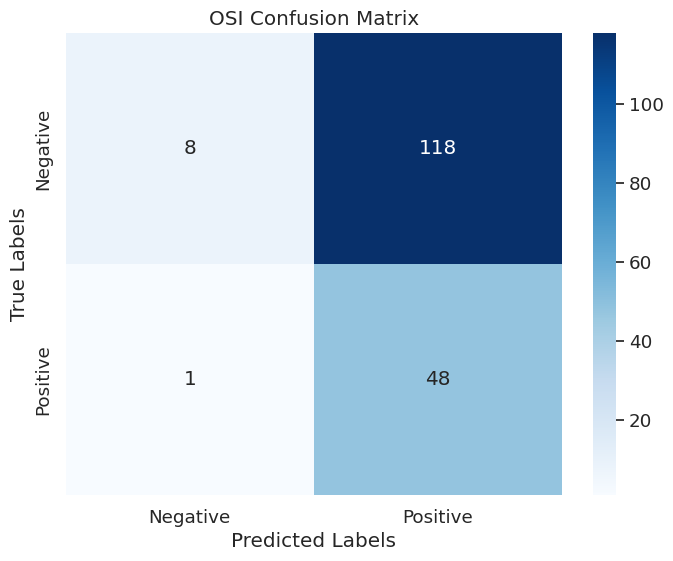

In [168]:
# best_cut 값을 사용하여 y_pred 생성
y_pred = [0 if value <= best_cut else 1 for value in data['OSI']]

conf_matrix = confusion_matrix(data['y'], y_pred)

labels = ["Negative", "Positive"]

# 혼동 행렬을 시각화
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("OSI Confusion Matrix")
plt.show()

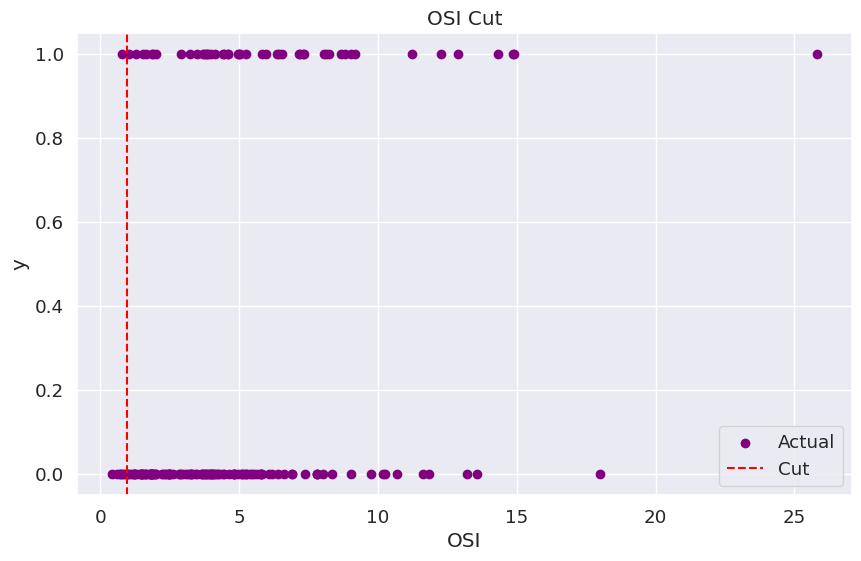

In [169]:
# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.scatter(sorted_OSI, sorted_y, color='purple', label='Actual')
plt.axvline(x=best_cut, color='red', linestyle='--', label='Cut')
plt.xlabel('OSI')
plt.ylabel('y')
plt.title('OSI Cut')
plt.legend()
plt.show()

In [170]:
data_1 = data[data['y']==1]['OSI']
data_0 = data[data['y']==0]['OSI']

print(data_1.median(),data_0.median())

5.049672761710233 3.551551769624969


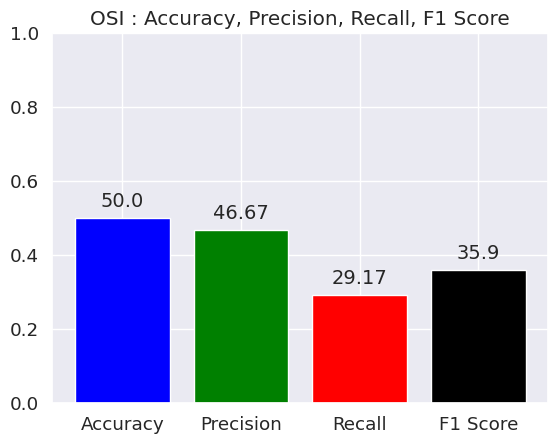

In [171]:
# 그래프 그리기
labels = ['Accuracy','Precision', 'Recall','F1 Score']
values = [best_accuracy, best_precision, best_recall, best_f1]

fig, ax = plt.subplots()
bars = ax.bar(labels, values, color=['blue', 'green','red','black'])
# plt.ylabel('Value')
plt.title('OSI : Accuracy, Precision, Recall, F1 Score')
plt.ylim(0, 1) 

# 막대 내부에 큰 글꼴 크기로 수치 표시
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4)*100, ha='center', va='bottom', fontsize=14)  # fontsize 조정

plt.show()

In [172]:
# y_pred 리스트 내의 값을 카운트
value_counts1 = Counter(data['y'])
value_counts2 = Counter(y_pred)

print("Value Counts:", value_counts1)
print("Value Counts:", value_counts2)

Value Counts: Counter({0: 126, 1: 49})
Value Counts: Counter({1: 166, 0: 9})
